<a href="https://colab.research.google.com/github/andresfelipegl/Pron-stico-Covid-19-series-de-tiempo-Modelo-ARIMA/blob/main/FINAL_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pronóstico del Covid 19 por medio de series de tiempo con el Modelo ARIMA**



##1. **Definición del problema**

---


Por su velocidad de propagación y su expansión a nivel mundial, el nuevo coronavirus se encuentra catalogado como pandemia por la Organización Mundial de la Salud.

En Colombia ya se han establecido diferentes normas y estrategias para abordar esta epidemia, sin embargo, la cantidad de muertes a causa de la enfermedad y la capacidad del sistema de salud para responder eficazmente a las necesidades de los pacientes infectados continuan preocupando a todo el país.
















##2. **Definición del problema de analítica**

---


En el siguiente estudio se pretende realizar una aproximación del comportamiento del virus a corto plazo con el modelo ARIMA ya que se puede pronosticar una serie de tiempo utilizando los valores pasados ​​de la serie para pronosticar su futuro. Este análisis se hace en 5 ciudades principales de Colombia. Medellín, Cali, Bogotá D.C., Cartagena de Indias y Barranquilla.

##3. **Datos**

---

###3.1. **Carga de datos**

Inicialmente la base de datos contaba con 21 campos, pero se considera que parte de ellos no son necesarios para el objetivo de predicción. Por esta razón, se seleccionan los siguientes campos: 


*   **ID:** Código único para diferenciar cada uno de los casos
*   **Fecha de notificación:** Fecha en el que se reporta el caso al sistema de salud público
*  **Ciudad de ubiación:** Ciudad donde se encuentra el contagiado
* **Departamento**: Departamento donde se encuentra el contagiado
*   **Atención:** El tipo de atención que requiere el contagiado, en este caso implica 6 categorías: 

  - *Casos Activos*= Personas infectadas que estan siendo tratadas desde casa, hospital o UCI
  - *Fallecidos*: Personas que murieron por Covid 19
  - *Recuperados:* Personas que lograron superar el Covid 19


*Para este caso no se consideraran las personas que presentan un estado de atención NA, dado que no se conoce si son personas fallecidas u hospitalizadas. Adicionalmente, este tipo de atención representa sobre el total de contagios de las 5 principales ciudades del país un 0.02%*

* **Edad**: Edad de los contagiados
* **Sexo**: Género de los contagiados
* **Tipo**: Forma en que la persona se infecto. En este caso se divide en tres categorías: 

 - *En estudio*: Casos para los cuáles no se ha determinado el tipo de contagio

 - *Importado*:  Casos que fueron importados desde otos países

 - *Relacionado*: Casos a los que se logra determinar el nexo de contagio

  **Estado**: Estado en el que se encuentra el contagiado. En este caso se divide en 6 categorías:

  - *Asintomático*: Personas contagiadas que no presenta síntomas

  - *Fallecido*: Personas que murieron por Covid 19

  - *Grave*: Personas que presentan graves síntomas por Covid 19

  - *Leve*: Personas que presentan ligeros síntomas por Covid 19

  - *Moderado*: Personas que presentan síntomas manejables por Covid 19

  - *NA*: Personas recuperadas o que se encuentran en estudio

*   **Fecha de muerte**: Fecha de muerte del contagiado por Covid 19
*   **Fecha recuperado**: Fecha de recuperación del contagiado por Covid 19
*   **Tipo de recuperacion**: Se divide en dos opciones:

  - *PCR*: Personas recuperadas en su segunda muestra

  - *Tiempo*: Personas que no son mayores de 70 años, no están hospitalizados y que pasados 30 días desde la fecha de inicio de síntomas no presentan signos de contagio

*   **Pertenencia etnica**: Se refiere a la identificación de las personas como integrantes de uno de los grupos étnicos, dichos grupos son: índigenas, negro, rom u otro
*   **Grupo etnico**: Grupo étnico al que pertenece la persona contagiada

---
Carga de datos

In [ ]:
!pip install sodapy

#Cargar datos

import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX


client = Socrata("www.datos.gov.co", None)
results = client.get("gt2j-8ykr",limit= 200000000)
results_df = pd.DataFrame.from_records(results)

#Elegir columnas

covid = results_df[['id_de_caso','fecha_de_notificaci_n','ciudad_de_ubicaci_n','departamento','atenci_n','edad','sexo','tipo','estado','fecha_recuperado','tipo_recuperaci_n','pertenencia_etnica','nombre_grupo_etnico','fecha_de_muerte']].copy()
# Cambio nombres
covid = covid.rename(columns={'id_de_caso':'ID','fecha_de_notificaci_n':'fecha_notificacion','ciudad_de_ubicaci_n':'ciudad_ubicacion', 'atenci_n': 'atencion','tipo_recuperaci_n':'tipo_recuperacion','nombre_grupo_etnico':'grupo_etnico','fecha_de_muerte':'fecha_muerte'})
#Cambio formato fecha
covid["fecha_notificacion"]= covid["fecha_notificacion"].str.split("T",2).str[0]
covid["fecha_recuperado"]= covid["fecha_recuperado"].str.split("T",2).str[0]
covid["fecha_muerte"]= covid["fecha_muerte"].str.split("T",2).str[0]
#ciudades principales
covid = covid[covid.ciudad_ubicacion.isin(['Medellín','Cali', 'Bogotá D.C.','Cartagena de Indias','Barranquilla'])]
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


 ### 3.2  **Análisis descriptivo**

Primero verificamos que haya cargado correctamente la base de datos para realizar el análisis. El comando **.columns** nos muestra las columnas importadas


In [ ]:
covid.columns

Index(['ID', 'fecha_notificacion', 'ciudad_ubicacion', 'departamento',
       'atencion', 'edad', 'sexo', 'tipo', 'estado', 'fecha_recuperado',
       'tipo_recuperacion', 'pertenencia_etnica', 'grupo_etnico',
       'fecha_muerte'],
      dtype='object')

In [ ]:
covid

,ID,fecha_notificacion,ciudad_ubicacion,departamento,atencion,edad,sexo,tipo,estado,fecha_recuperado,tipo_recuperacion,pertenencia_etnica,grupo_etnico,fecha_muerte
0,1,2020-03-02,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,2020-03-13,PCR,Otro,NaN,NaN
2,3,2020-03-07,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,2020-03-15,PCR,Otro,NaN,NaN
3,4,2020-03-09,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,2020-03-26,PCR,Otro,NaN,NaN
4,5,2020-03-09,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,2020-03-23,PCR,Otro,NaN,NaN
6,7,2020-03-08,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,Leve,2020-03-17,PCR,Otro,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658445,658486,2020-08-23,Medellín,Antioquia,Casa,20,M,En estudio,Leve,NaN,NaN,NaN,NaN,NaN
658447,658488,2020-08-24,Medellín,Antioquia,Casa,21,M,En estudio,Leve,NaN,NaN,NaN,NaN,NaN
658450,658491,2020-08-23,Medellín,Antioquia,Casa,17,M,En estudio,Leve,NaN,NaN,NaN,NaN,NaN
658451,658492,2020-08-22,Medellín,Antioquia,Casa,18,M,En estudio,Leve,NaN,NaN,NaN,NaN,NaN


El modelo ARIMA, de la abreviatura del inglés ‘Auto Regressive Integrated Moving Average’, es una clase de modelos que 'explica' una serie de tiempo determinada en función de sus propios valores pasados, es decir, gracias a los datos existentes se puede utilizar para pronosticar valores futuros.

Cualquier serie de tiempo "no estacional" que muestre patrones y no sea un ruido blanco aleatorio se puede modelar con modelos ARIMA.

Un modelo ARIMA se caracteriza por 3 términos: p, d, q

dónde,

p es el orden del término AR

d es el número de diferenciaciones necesarias para que la serie temporal sea estacionaria

q es el orden del término MA


---
#Predicción de nuevos contagios en Medellín, Cali, Bogotá D.C.,Cartagena de Indias y Barranquilla 

---
A continuación se ordena la tabla en orden ascendente por **fecha_notificacion** que es la fecha en que se notifica un nuevo contagio

In [ ]:
covid_CasosNuevos = covid.sort_values(by='fecha_notificacion',ascending=True)
covid_CasosNuevos

,ID,fecha_notificacion,ciudad_ubicacion,departamento,atencion,edad,sexo,tipo,estado,fecha_recuperado,tipo_recuperacion,pertenencia_etnica,grupo_etnico,fecha_muerte
0,1,2020-03-02,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,2020-03-13,PCR,Otro,NaN,NaN
2,3,2020-03-07,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,2020-03-15,PCR,Otro,NaN,NaN
6,7,2020-03-08,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,Leve,2020-03-17,PCR,Otro,NaN,NaN
8,9,2020-03-08,Bogotá D.C.,Bogotá D.C.,Recuperado,28,F,Importado,Leve,2020-03-23,PCR,Otro,NaN,NaN
3,4,2020-03-09,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,2020-03-26,PCR,Otro,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653166,653207,2020-09-05,Bogotá D.C.,Bogotá D.C.,Casa,38,M,En estudio,Leve,NaN,NaN,NaN,NaN,NaN
653167,653208,2020-09-05,Bogotá D.C.,Bogotá D.C.,Casa,22,F,En estudio,Leve,NaN,NaN,NaN,NaN,NaN
653168,653209,2020-09-05,Bogotá D.C.,Bogotá D.C.,Casa,59,F,En estudio,Leve,NaN,NaN,NaN,NaN,NaN
653161,653202,2020-09-05,Bogotá D.C.,Bogotá D.C.,Casa,31,M,En estudio,Leve,NaN,NaN,NaN,NaN,NaN


El siguiente comando nos agrupa la cantidad de **ID** por **fecha_notificacion** y así obtener el acumulado de nuevos contagios hasta la fecha

In [ ]:
covid_CasosNuevos = covid_CasosNuevos.groupby('fecha_notificacion')['ID'].nunique()
covid_CasosNuevos

fecha_notificacion
2020-03-02       1
2020-03-07       1
2020-03-08       2
2020-03-09       3
2020-03-11       8
              ... 
2020-09-01    2172
2020-09-02    1593
2020-09-03     335
2020-09-04     130
2020-09-05      14
Name: ID, Length: 183, dtype: int64

---
El primer paso para construir un modelo ARIMA es hacer estacionaria la serie de tiempo.

El término "Auto regresivo" en ARIMA significa que es un modelo de regresión lineal que utiliza sus propios retrasos como predictores.

Para hacer estacionaria una serie, la práctica más común es hacer una diferenciación. Es decir, restar el valor anterior del valor actual. A veces, dependiendo de la complejidad de la serie, es posible que se necesite más de una diferenciación.

El valor de "d", por lo tanto, es el número mínimo de diferenciaciones necesarias para hacer estacionaria la serie. Si la serie de tiempo ya es estacionaria, entonces d = 0.

---

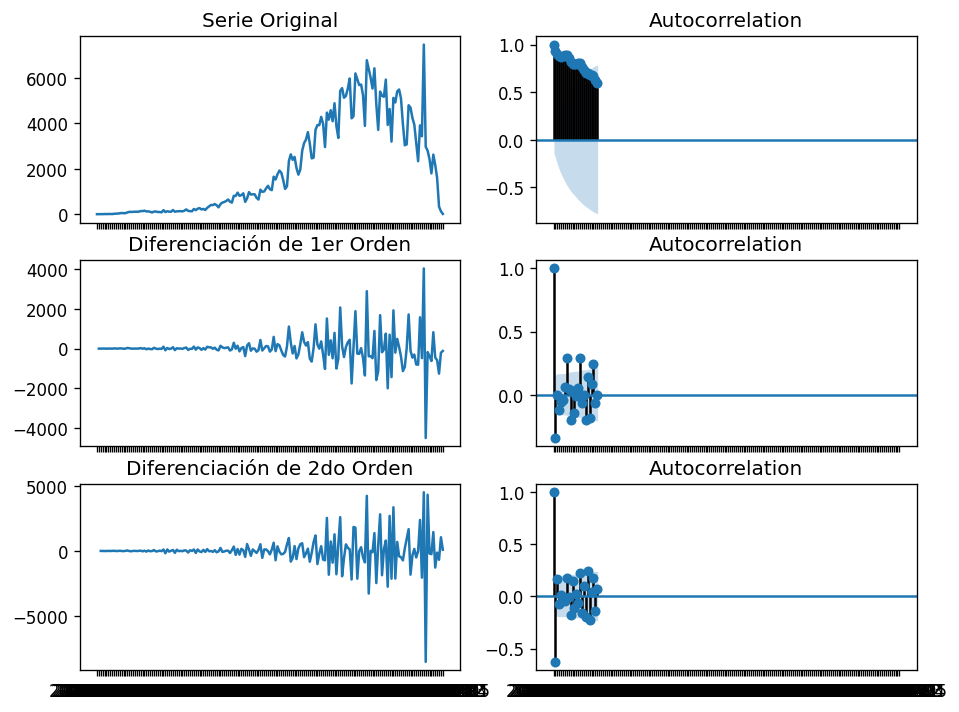

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Serie Original
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(covid_CasosNuevos); axes[0, 0].set_title('Serie Original')
plot_acf(covid_CasosNuevos, ax=axes[0, 1])

# Diferenciación de 1er Orden
axes[1, 0].plot(covid_CasosNuevos.diff()); axes[1, 0].set_title('Diferenciación de 1er Orden')
plot_acf(covid_CasosNuevos.diff().dropna(), ax=axes[1, 1])

# Diferenciación de 2do Orden
axes[2, 0].plot(covid_CasosNuevos.diff().diff()); axes[2, 0].set_title('Diferenciación de 2do Orden')
plot_acf(covid_CasosNuevos.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

---
A continuación se determinan los valores "p" y "q"

---

El término de AR requerido se puede determinar inspeccionando el gráfico de Autocorrelación parcial (PACF).

---
Cualquier autocorrelación en una serie estacionarizada puede rectificarse agregando suficientes términos AR. Entonces, inicialmente se toma el orden del término AR como igual a tantos rezagos que cruzan el límite de significancia (región azul) en la gráfica PACF.

---
Ya que el 2do Orden de diferenciación nos daba una serie más estacionaria que la diferenciación de 1er Orden, se obtiene la Autocorrelación parcial para el 2do Orden de diferenciación

Gráfico PACF, valor "p"

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


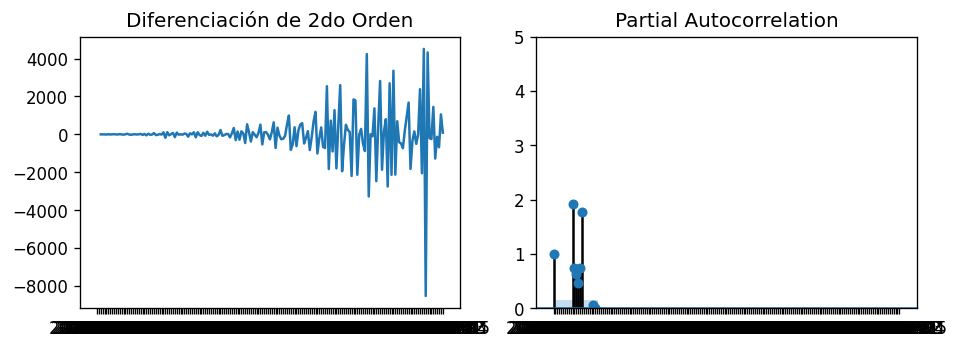

In [ ]:
# Plot PACF diferenciación de 2do Orden
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(covid_CasosNuevos.diff().diff()); axes[0].set_title('Diferenciación de 2do Orden')
axes[1].set(ylim=(0,5))
plot_pacf(covid_CasosNuevos.diff().diff().dropna(), ax=axes[1])

plt.show()

---
De la misma manera que observamos el gráfico PACF para el número de términos AR, se observa el gráfico ACF para el número de términos MA. Un término MA es técnicamente el error del pronóstico retrasado.

El ACF indica cuántos términos MA se requieren para eliminar cualquier autocorrelación en la serie estacionaria.

Gráfico ACF, valor "q"

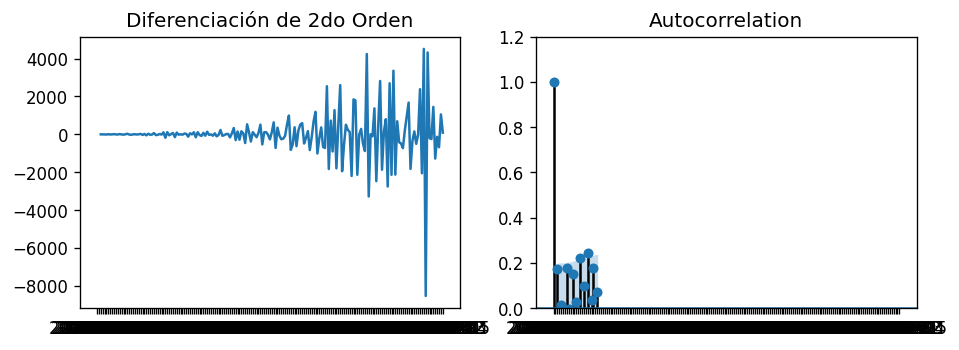

In [ ]:
# Plot ACF diferenciación de 2do Orden
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(covid_CasosNuevos.diff().diff()); axes[0].set_title('Diferenciación de 2do Orden')
axes[1].set(ylim=(0,1.2))
plot_acf(covid_CasosNuevos.diff().diff().dropna(), ax=axes[1])

plt.show()

---
Si una serie está ligeramente por debajo de la diferencia, agregar uno o más términos AR adicionales generalmente lo compensa. Del mismo modo, si está ligeramente sobrediferenciado, se intenta agregar un término MA adicional.
---

Una vez se tienen los valores de p, d y q, se implementa el modelo **ARIMA()** del paquete statsmodels.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# Modelo ARIMA 
model = ARIMA(covid_CasosNuevos, order=(9,2,2))
model_fit = model.fit(disp=0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


---
Se grafican los datos reales contra los valores ajustados usando **plot_predict()**

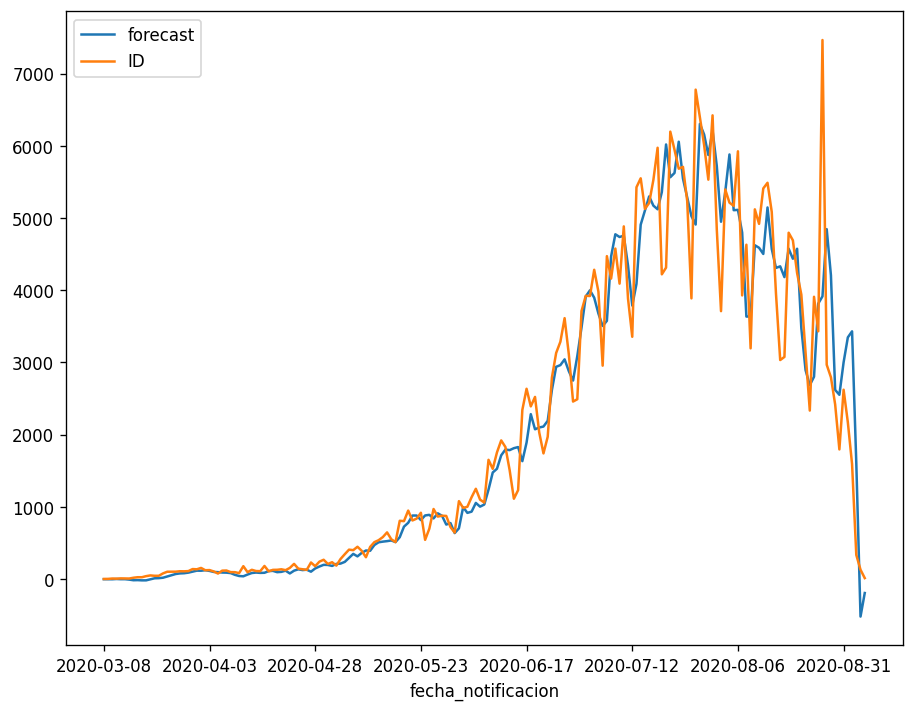

In [ ]:
# Real vs Ajustada
model_fit.plot_predict(dynamic=False)
plt.show()

Cuando se establece dynamic = False, el modelo se entrena hasta el valor anterior para realizar la siguiente predicción. Esto puede hacer que el pronóstico ajustado y los datos reales se vean artificialmente bien.

Por lo tanto, la "validación real" que se necesita ahora es la validación cruzada fuera de tiempo, para esto, se debe crear el conjunto de datos de entrenamiento y prueba dividiendo la serie de tiempo en 2 partes.

Para la predicción de nuevos contagios se toma una relación del 85% de datos para entrenamiento y el restante para realizar el testeo del modelo

In [ ]:
porcentajeTrain_casosnuevos=int((covid_CasosNuevos.size)*0.85)#0.92
porcentajeTrain_casosnuevos

155

In [ ]:
train_casosnuevos = covid_CasosNuevos[:porcentajeTrain_casosnuevos]
test_casosnuevos = covid_CasosNuevos[porcentajeTrain_casosnuevos:]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


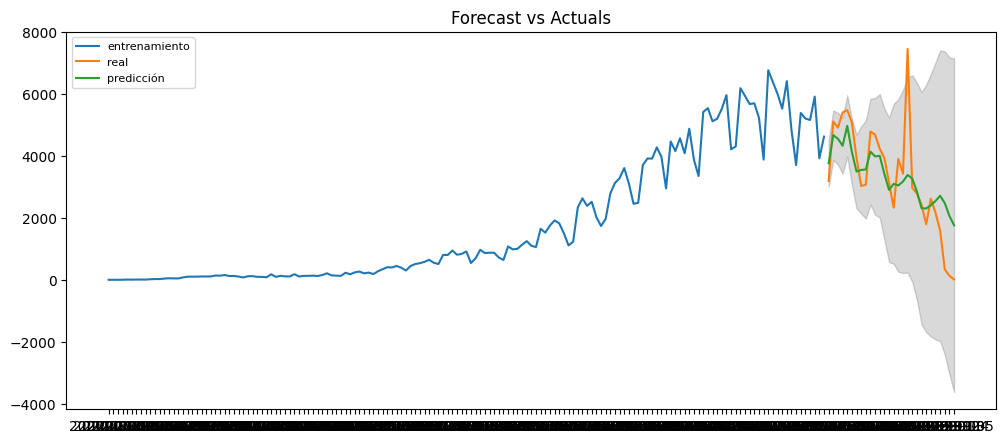

In [ ]:
# model = ARIMA(train, order=(10,2,2))  
model = ARIMA(train_casosnuevos, order=(9,2,2))  #10,2,2 con 92%
fitted = model.fit(disp=-1)  

# Predicción
fc, se, conf = fitted.forecast(len(test_casosnuevos), alpha=0.05)#0.05  # 95% conf

# Se transforma a pandas series
fc_series = pd.Series(fc, index=test_casosnuevos.index)
lower_series = pd.Series(conf[:, 0], index=test_casosnuevos.index)
upper_series = pd.Series(conf[:, 1], index=test_casosnuevos.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_casosnuevos, label='entrenamiento')
plt.plot(test_casosnuevos, label='real')
plt.plot(fc_series, label='predicción')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

A partir del gráfico, el modelo ARIMA (10,2,2) parece dar un pronóstico direccionalmente correcto. Y los valores reales observados se encuentran dentro de la banda de confianza del 95%. 

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
#Métrica de precisión
np.sqrt(mean_squared_error(test_casosnuevos,fc_series))

1137.283446544838

## Para el proceso de pronóstico de fallecidos y recuperados, se realiza la misma secuencia de pasos para determinar los valores de (p,d,q) del modelo ARIMA y se ejecuta la predicción. Teniendo en cuenta que por motivos de sub ajustes o sobre ajustes, se pueden agregar valores tanto al orden de AR como de MA.

# Fallecidos en Medellín, Cali, Bogotá D.C.,Cartagena de Indias y Barranquilla 


---
A continuación se ordena la tabla en orden ascendente por **fecha_muerte** que es la fecha en que se notifica una nueva muerte

In [ ]:
covid_Fallecidos = covid[covid.atencion.isin(["Fallecido"])]
covid_Fallecidos = covid_Fallecidos.sort_values(by='fecha_muerte',ascending=True)
covid_Fallecidos

,ID,fecha_notificacion,ciudad_ubicacion,departamento,atencion,edad,sexo,tipo,estado,fecha_recuperado,tipo_recuperacion,pertenencia_etnica,grupo_etnico,fecha_muerte
196,197,2020-03-13,Cartagena de Indias,Cartagena D.T. y C.,Fallecido,58,M,Relacionado,Fallecido,NaN,NaN,Otro,NaN,2020-03-16
721,722,2020-03-24,Cali,Valle del Cauca,Fallecido,68,M,Relacionado,Fallecido,NaN,NaN,Otro,NaN,2020-03-25
249,250,2020-03-23,Bogotá D.C.,Bogotá D.C.,Fallecido,76,M,En estudio,Fallecido,NaN,NaN,Otro,NaN,2020-03-25
618,619,2020-03-28,Cali,Valle del Cauca,Fallecido,36,M,Relacionado,Fallecido,NaN,NaN,Otro,NaN,2020-03-25
490,491,2020-03-25,Bogotá D.C.,Bogotá D.C.,Fallecido,84,M,Relacionado,Fallecido,NaN,NaN,Otro,NaN,2020-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544328,544369,2020-08-22,Bogotá D.C.,Bogotá D.C.,Fallecido,69,M,En estudio,Fallecido,NaN,NaN,NaN,NaN,2020-09-05
404927,404968,2020-08-05,Bogotá D.C.,Bogotá D.C.,Fallecido,81,M,En estudio,Fallecido,NaN,NaN,NaN,NaN,2020-09-05
367200,367241,2020-08-07,Medellín,Antioquia,Fallecido,76,M,En estudio,Fallecido,NaN,NaN,NaN,NaN,2020-09-05
523388,523429,2020-08-18,Cali,Valle del Cauca,Fallecido,78,M,En estudio,Fallecido,NaN,NaN,NaN,NaN,2020-09-05


Agrupación de datos

In [ ]:
covid_Fallecidos = covid_Fallecidos.groupby('fecha_muerte')['ID'].nunique()
covid_Fallecidos

fecha_muerte
2020-03-16     1
2020-03-25     3
2020-03-26     2
2020-03-27     1
2020-03-28     3
              ..
2020-09-01    79
2020-09-02    69
2020-09-03    63
2020-09-04    71
2020-09-05    11
Name: ID, Length: 166, dtype: int64

Diferenciación, valor de "d"

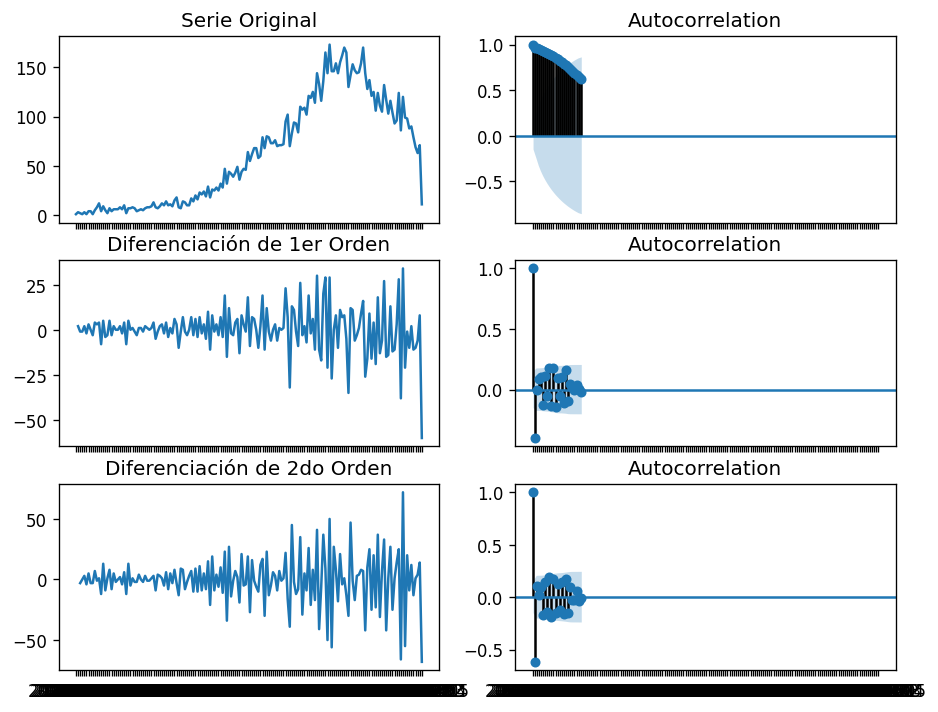

In [ ]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Serie Original
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(covid_Fallecidos); axes[0, 0].set_title('Serie Original')
plot_acf(covid_Fallecidos, ax=axes[0, 1])

# Diferenciación de 1er Orden
axes[1, 0].plot(covid_Fallecidos.diff()); axes[1, 0].set_title('Diferenciación de 1er Orden')
plot_acf(covid_Fallecidos.diff().dropna(), ax=axes[1, 1])

# Diferenciación de 2do Orden
axes[2, 0].plot(covid_Fallecidos.diff().diff()); axes[2, 0].set_title('Diferenciación de 2do Orden')
plot_acf(covid_Fallecidos.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Gráfico PACF, valor de "p"

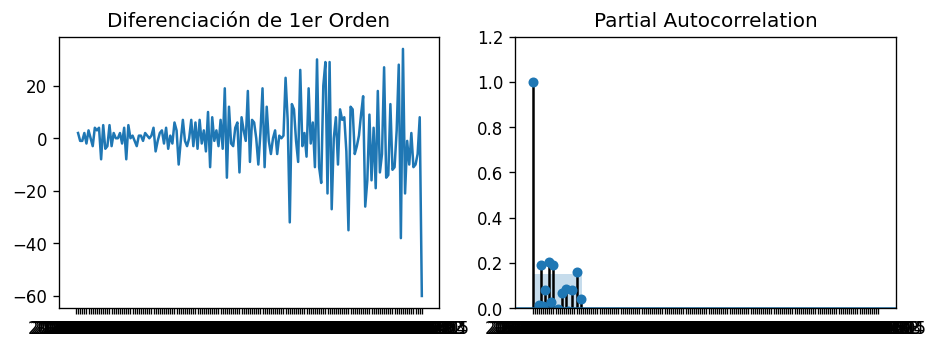

In [ ]:
# Plot PACF diferenciación de 1er Orden
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(covid_Fallecidos.diff()); axes[0].set_title('Diferenciación de 1er Orden')
axes[1].set(ylim=(0,1.2))
plot_pacf(covid_Fallecidos.diff().dropna(), ax=axes[1])

plt.show()

Gráfico ACF, valor de "q"

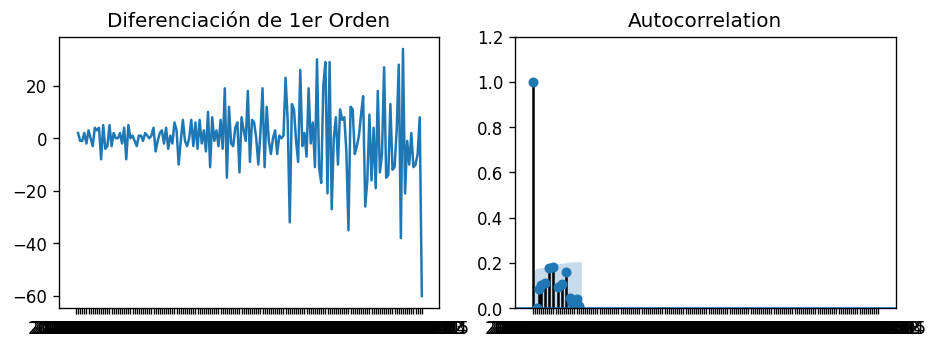

In [ ]:
# Plot ACF diferenciación de 1er Orden
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(covid_Fallecidos.diff()); axes[0].set_title('Diferenciación de 1er Orden')
axes[1].set(ylim=(0,1.2))
plot_acf(covid_Fallecidos.diff().dropna(), ax=axes[1])

plt.show()

Modelo ARIMA

In [ ]:
# Modelo ARIMA
model_fallecidos = ARIMA(covid_Fallecidos, order=(8,1,2))
model_fit_fallecidos = model_fallecidos.fit(disp=0)
#print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Gráfico de los datos reales contra los valores ajustados usando **plot_predict()**


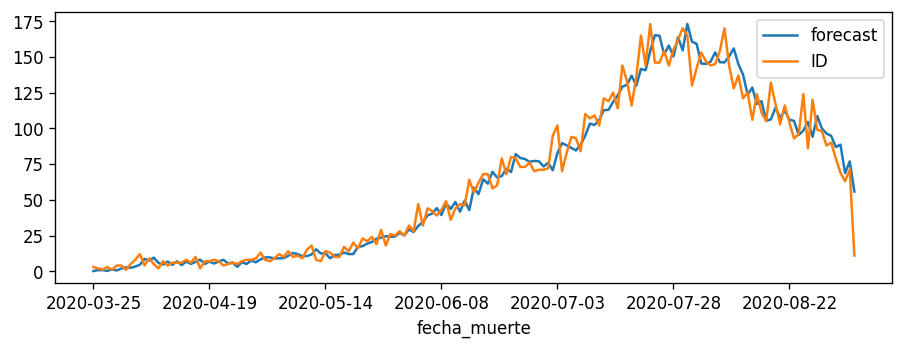

In [ ]:
model_fit_fallecidos.plot_predict(dynamic=False)
plt.show()

División de la serie de tiempo

Para la predicción de fallecidos se toma una relación del 90% de datos para entrenamiento y el restante para realizar el testeo del modelo

In [ ]:
porcentajeTrain_fallecidos=int((covid_Fallecidos.size)*0.90)
porcentajeTrain_fallecidos

149

In [ ]:
train_fallecidos = covid_Fallecidos[:porcentajeTrain_fallecidos]
test_fallecidos = covid_Fallecidos[porcentajeTrain_fallecidos:]

Modelo ARIMA de predicción

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


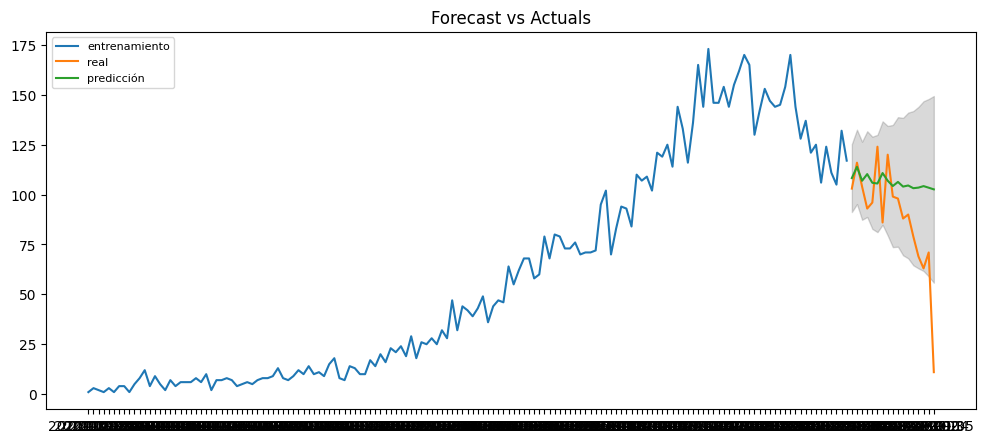

In [ ]:
#Modelo ARIMA  
model_fallecidos = ARIMA(train_fallecidos, order=(9,1,2))  
fitted = model_fallecidos.fit(disp=-1)  

# Predicción
fc, se, conf = fitted.forecast(len(test_fallecidos), alpha=0.05)#0.05  # 95% conf

# Transformación a pandas series
fc_series_fallecidos = pd.Series(fc, index=test_fallecidos.index)
lower_series = pd.Series(conf[:, 0], index=test_fallecidos.index)
upper_series = pd.Series(conf[:, 1], index=test_fallecidos.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_fallecidos, label='entrenamiento')
plt.plot(test_fallecidos, label='real')
plt.plot(fc_series_fallecidos, label='predicción')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Precisión del modelo

In [ ]:
np.sqrt(mean_squared_error(test_fallecidos,fc_series_fallecidos))

29.75609406895779

#Recuperados en Medellín, Cali, Bogotá D.C.,Cartagena de Indias y Barranquilla 


---
A continuación se ordena la tabla en orden ascendente por **fecha_recuperado** que es la fecha en que se notifica la recuperación de un contagiado

In [ ]:
covid_Recuperados = covid[covid.atencion.isin(["Recuperado"])]
covid_Recuperados = covid_Recuperados.sort_values(by='fecha_recuperado',ascending=True)
covid_Recuperados

,ID,fecha_notificacion,ciudad_ubicacion,departamento,atencion,edad,sexo,tipo,estado,fecha_recuperado,tipo_recuperacion,pertenencia_etnica,grupo_etnico,fecha_muerte
0,1,2020-03-02,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,2020-03-13,PCR,Otro,NaN,NaN
16,17,2020-03-11,Bogotá D.C.,Bogotá D.C.,Recuperado,73,F,Importado,Leve,2020-03-14,PCR,Otro,NaN,NaN
2,3,2020-03-07,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,2020-03-15,PCR,Otro,NaN,NaN
6,7,2020-03-08,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,Leve,2020-03-17,PCR,Otro,NaN,NaN
54,55,2020-03-16,Bogotá D.C.,Bogotá D.C.,Recuperado,58,F,Relacionado,Leve,2020-03-20,PCR,Otro,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142816,142857,2020-07-08,Bogotá D.C.,Bogotá D.C.,Recuperado,55,M,En estudio,Moderado,2020-09-05,Tiempo,Otro,NaN,NaN
142778,142819,2020-07-04,Bogotá D.C.,Bogotá D.C.,Recuperado,61,M,En estudio,Moderado,2020-09-05,Tiempo,Otro,NaN,NaN
142700,142741,2020-07-06,Bogotá D.C.,Bogotá D.C.,Recuperado,64,M,En estudio,Moderado,2020-09-05,Tiempo,Otro,NaN,NaN
143071,143112,2020-07-07,Bogotá D.C.,Bogotá D.C.,Recuperado,52,F,En estudio,Moderado,2020-09-05,Tiempo,Otro,NaN,NaN


Agrupación de datos

In [ ]:
covid_Recuperados = covid_Recuperados.groupby('fecha_recuperado')['ID'].nunique()
covid_Recuperados

fecha_recuperado
2020-03-13       1
2020-03-14       1
2020-03-15       1
2020-03-17       1
2020-03-20       1
              ... 
2020-09-01    6456
2020-09-02    5213
2020-09-03    3386
2020-09-04    2878
2020-09-05    5488
Name: ID, Length: 174, dtype: int64

Diferenciación, valor de "d"

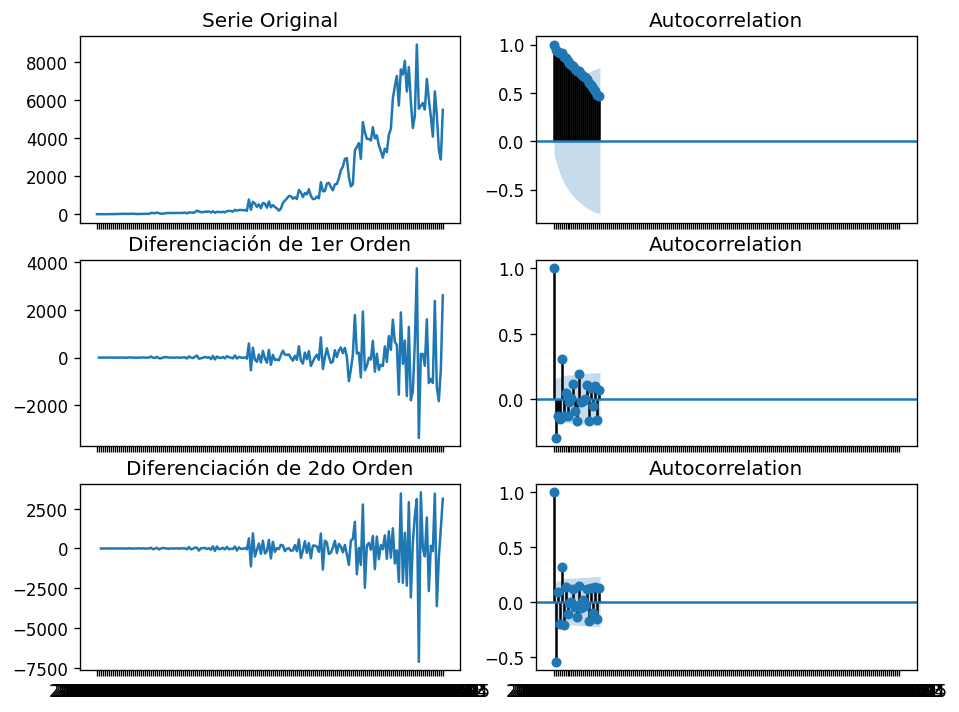

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Serie Original
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(covid_Recuperados); axes[0, 0].set_title('Serie Original')
plot_acf(covid_Recuperados, ax=axes[0, 1])

# Diferenciación de 1er Orden
axes[1, 0].plot(covid_Recuperados.diff()); axes[1, 0].set_title('Diferenciación de 1er Orden')
plot_acf(covid_Recuperados.diff().dropna(), ax=axes[1, 1])

# Diferenciación de 2do Orden
axes[2, 0].plot(covid_Recuperados.diff().diff()); axes[2, 0].set_title('Diferenciación de 2do Orden')
plot_acf(covid_Recuperados.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Gráfico PACF, valor de "p"

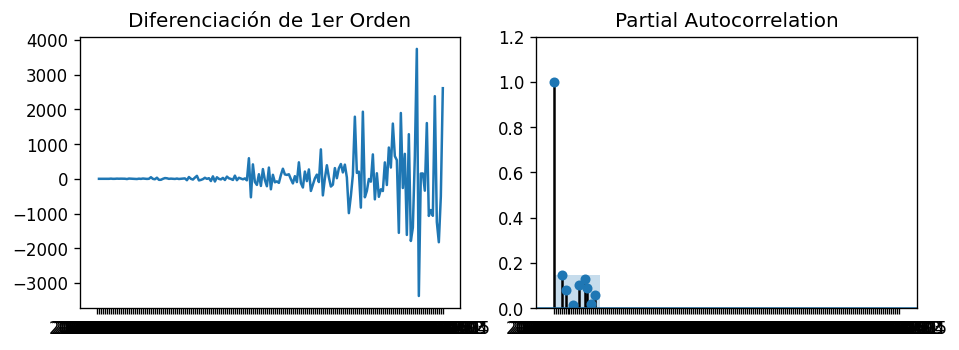

In [ ]:
# Plot PACF diferenciación de 1er Orden
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(covid_Recuperados.diff()); axes[0].set_title('Diferenciación de 1er Orden')
axes[1].set(ylim=(0,1.2))
plot_pacf(covid_Recuperados.diff().dropna(), ax=axes[1])

plt.show()

Gráfico ACF, valor de "q"

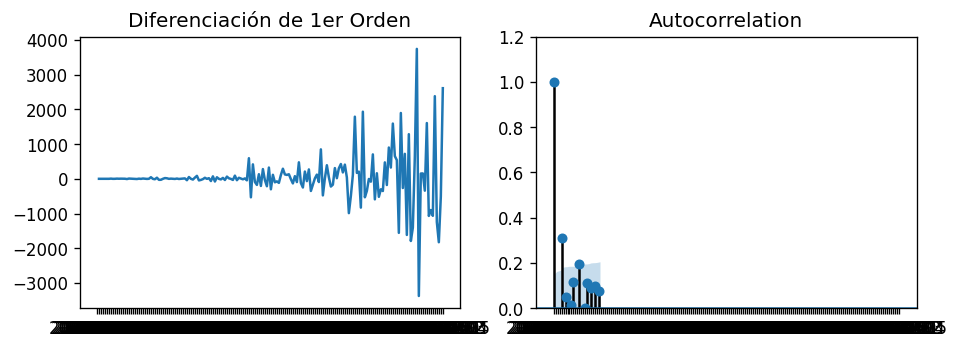

In [ ]:
# Plot ACF diferenciación de 1er Orden
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(covid_Recuperados.diff()); axes[0].set_title('Diferenciación de 1er Orden')
axes[1].set(ylim=(0,1.2))
plot_acf(covid_Recuperados.diff().dropna(), ax=axes[1])

plt.show()

Modelo ARIMA

In [ ]:
model_recuperados = ARIMA(covid_Recuperados, order=(5,1,2))
model_fit_recuperados = model_recuperados.fit(disp=0)
#print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Gráfico de los datos reales contra los valores ajustados usando **plot_predict()**

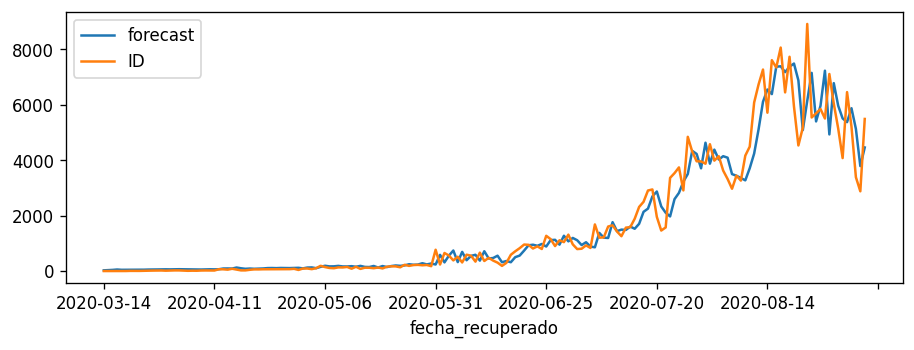

In [ ]:
model_fit_recuperados.plot_predict(dynamic=False)
plt.show()

División de la serie de tiempo

Para la predicción de recuperados se toma una relación del 92% de datos para entrenamiento y el restante para realizar el testeo del modelo

In [ ]:
porcentajeTrain_recuperados=int((covid_Recuperados.size)*0.92)
porcentajeTrain_recuperados

160

In [ ]:
train_Recuperados = covid_Recuperados[:porcentajeTrain_recuperados]
test_Recuperados = covid_Recuperados[porcentajeTrain_recuperados:]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


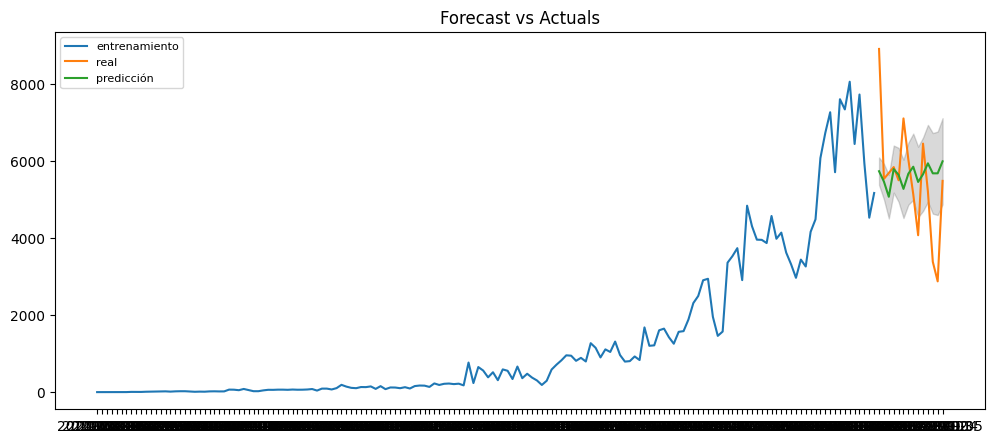

In [ ]:
# Contrucción Modelo ARIMA 
model_recuperados = ARIMA(train_Recuperados, order=(5,1,2))  
fitted = model_recuperados.fit(disp=-1)  

# Predicción
fc, se, conf = fitted.forecast(steps=len(test_Recuperados), alpha=0.4)#0.05  # 95% conf

#predictions_arima_Fallecidos = fitted.forecast(steps=20)[0] #quiero predecir 18 valores ([0] hace que solo tome la 
#primer parte del arreglo, los cuales serían los valores predecidos)
#print(predictions_arima_Fallecidos)

# Transformación a pandas series
fc_series_recuperados = pd.Series(fc, index=test_Recuperados.index)
lower_series = pd.Series(conf[:, 0], index=test_Recuperados.index)
upper_series = pd.Series(conf[:, 1], index=test_Recuperados.index)
#print(fc_series_recuperados)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_Recuperados, label='entrenamiento')
plt.plot(test_Recuperados, label='real')
plt.plot(fc_series_recuperados, label='predicción')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Precisión del modelo

In [ ]:
np.sqrt(mean_squared_error(test_Recuperados,fc_series_recuperados))

1487.676084077568